In [35]:
from FastSAM.fastsam import FastSAM, FastSAMPrompt
import cv2
from matplotlib import pyplot as plt
import os
import shutil
import torch
import numpy as np
import clip 


image 1/1 /home/sorb/projects/zero_shot_dataset/simple_images/people/people_7.jpg: 704x1024 45 objects, 15.8ms
Speed: 3.1ms preprocess, 15.8ms inference, 2.7ms postprocess per image at shape (1, 3, 1024, 1024)


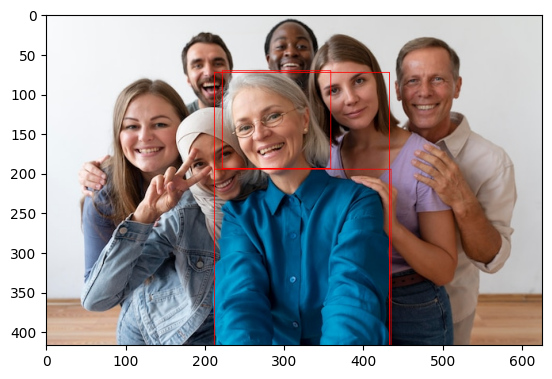

In [71]:
# parameters
IMAGE_PATH = "simple_images/people/people_7.jpg"
TEXT_PROMPT= 'a picture of person'
CLIP_THRESHOLD = 0.1
DEVICE = 'cuda'

# load the model
model = FastSAM('FastSAM/weights/FastSAM-x.pt')

# load the clip model
clip_model, preprocess = clip.load('ViT-B/32', device=prompt_process.device)

# read original image
img = cv2.imread(IMAGE_PATH)

# inference
everything_results = model(IMAGE_PATH, device=DEVICE, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9)

# create the prompt process
prompt_process = FastSAMPrompt(IMAGE_PATH, everything_results, device=DEVICE)

# implementation of own prompt method
bboxes = []
if everything_results != None:
    format_results = prompt_process._format_results(everything_results[0], 0)
    cropped_boxes, cropped_images, not_crop, filter_id, annotations = prompt_process._crop_image(format_results)
    scores = prompt_process.retrieve(clip_model, preprocess, cropped_boxes, TEXT_PROMPT, device=prompt_process.device)
    ann = []
    indices = torch.nonzero(scores > CLIP_THRESHOLD).squeeze().tolist()
    
    # convert to array
    if type(indices) is int:
        indices = [indices]

    for ind in indices:
        bbox = prompt_process._get_bbox_from_mask(np.uint8(annotations[ind]['segmentation']) * 255)
        bboxes.append(bbox)

        # draw bbox
        cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255))


# plot
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()


In [37]:
# # parameters
# CLEAN_FOLDER = True
# PLOT_IMAGES = True
# BREAK_AFTER = 0 # if > 0, break after this many images
# BOX_TRESHOLD = 0.5
# TEXT_TRESHOLD = 0.25


# classes = ['hard hat', 'safety glasses', 'person']

# input_folder = 'simple_images/test'
# output_folder = 'output_folder'
# image_folder = os.path.join(output_folder, 'images')
# annotation_folder = os.path.join(output_folder, 'annotations')

# # if clean folder is true, delete the output folder
# if CLEAN_FOLDER:
#     shutil.rmtree(output_folder)

# # if output folder does not exist, create it
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)
#     os.makedirs(image_folder)
#     os.makedirs(annotation_folder)
  
# # get all images in the input folder
# images = os.listdir(input_folder)

# # for each image in the input folder
# for idx, file in enumerate(images):

#     # create the full input path and read the file
#     input_path = os.path.join(input_folder, file)
#     image_source, image = load_image(input_path)

#     # move image to gpu
#     image.to(device)

#     out_boxes = []
#     out_logits = []
#     out_phrases = []

#     # for each class
#     for class_name in classes:
#         with torch.no_grad():
            
#             TEXT_PROMPT = class_name
#             # predict the bounding boxes, logits and phrases
#             boxes, logits, phrases = predict(
#                 model=model,
#                 image=image,
#                 caption=TEXT_PROMPT,
#                 box_threshold=BOX_TRESHOLD,
#                 text_threshold=TEXT_TRESHOLD
#             )

#             # append the results to the output lists
#             out_boxes.append(boxes)
#             out_logits.append(logits)
#             out_phrases.append([class_name for i in range(len(boxes))])
    
#     # stack the output lists
#     out_boxes = torch.cat(out_boxes, dim=0)
#     out_logits = torch.cat(out_logits, dim=0)
#     out_phrases = [phrase for sublist in out_phrases for phrase in sublist]
    
#     # if the model finds any bounding boxes
#     if len(out_boxes) > 0:
        
#         if PLOT_IMAGES:
#             # create annotations show the image using opencv and matplotlib
#             annotated_frame = annotate(image_source=image_source, boxes=out_boxes, logits=out_logits, phrases=out_phrases)
#             plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
#             plt.show()

#         # write the image to the image folder
#         image_path = os.path.join(image_folder, file)
#         cv2.imwrite(image_path, image_source)

#         # create the annotation file
#         annotation_file = file.replace('.jpg', '.txt')
#         annotation_path = os.path.join(annotation_folder, annotation_file)

#         # open the annotation file
#         with open(annotation_path, 'w') as f:
            
#             # convert out phrases to indices
#             out_phrases = [classes.index(s) for s in out_phrases]

#             # for each bounding box
#             for box, logits, phrase in zip(out_boxes, out_logits, out_phrases):
#                 # write the bounding box to the file
#                 f.write(f"{phrase} {box[0]} {box[1]} {box[2]} {box[3]}\n")

#     if BREAK_AFTER > 0 and idx == BREAK_AFTER:
#         break
    
    

    